# Data Wrangling Project

### Research Question:
- **What is the impact of PM 2.5 on premature deaths in Milan, Italy?**

#### Sub questions
- What is the impact of the polluants - NO2, O3, PM 2.5 - on premature deaths in Sassari (Sardegna, Italy) and Milan (Lombardy, Italy)? And how do the two cities compare?
- What is the impact of other particles like N02 and O3 compared to PM 2.5 ?
- How does Milan level of PM 2.5 and its impact on pollution compare to other major European cities?

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

#### Cleaning and Pre-Processing of data

In [2]:
# read in Milan data - polluants: N02, O3, PM 2.5 between 2005 and 2021
df_milan = pd.read_csv("data_sets/milan.csv").dropna()
df_milan = df_milan.drop(columns=["City Boundary Specification (LAU/grid)", 'Country Or Territory', 'City', 'City Code', 'Health Risk Scenario', 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI'])

# read in Sassari data - polluants: N02, O3, PM 2.5 between 2005 and 2021
df_sassari = pd.read_csv("data_sets/sassari.csv").dropna()
df_sassari = df_sassari.drop(columns=["City Boundary Specification (LAU/grid)", 'Country Or Territory', 'City', 'City Code', 'Health Risk Scenario', 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI'])

# read in in Italian deaths attributed to PM 2.5 between 2005 and 2021
data_italy = pd.read_csv("data_sets/Italy_deaths_pm25.csv")
data_italy_filt = data_italy.drop(['Country Or Territory', 'Degree Of Urbanisation',
        'Air Pollutant', 'Health Risk Scenario', 'Population',
        'Populated Area [km2]', 'Air Pollution Average [ug/m3]',
        'Air Pollution Population Weighted Average [ug/m3]',
        'Premature Deaths - lower CI', 'Premature Deaths - upper CI',
        'Years Of Life Lost', 'Years Of Life Lost - lower CI',
        'Years Of Life Lost - upper CI'], axis=1)

# European main cities PM 2.5 levels and impact on premature death between 2005 and 2021
eur_cities = ["milan", "berlin", "paris", "warsaw", "amsterdam", "dublin", "ljubljana", "stockholm", "zagreb", "helsinki"]
eur_cities_df = []
for city in eur_cities:
    df_city = pd.read_csv(f"data_sets/europe_cities_pm25/{city}.csv")
    df_city = df_city.drop(columns=["City Boundary Specification (LAU/grid)", 'Country Or Territory', 'City Code', 'Health Risk Scenario', "Air Pollution Average [ug/m3]", 'Premature Deaths - lower CI', 'Premature Deaths - upper CI', 'Years Of Life Lost', 'Years Of Life Lost - lower CI', 'Years Of Life Lost - upper CI'])
    df_city['City'] = city 
    eur_cities_df.append(df_city)
eur_cities = pd.concat(eur_cities_df, ignore_index=True)

### Groupings and Visualizations

In [3]:
def graph_prem_deaths_city(data_frame_group_year, pollutants, city, n_pollutants=3):
    plt.figure(figsize=(16, 8))
    
    for i, pollutant in enumerate(pollutants, 1):
        if i <= 2: 
            plt.subplot(2, 2, i)
        else: 
            plt.subplot(2, 2, i)

        subset = data_frame_group_year.loc[pollutant]

        plt.plot(subset.index, subset['Air Pollution Population Weighted Average [ug/m3]'], label='Air Pollution')
        plt.plot(subset.index, subset['Premature Deaths'], label='Premature Deaths', linestyle='--')

        plt.title(f'Trends for {pollutant} {city}')
        plt.xlabel('Year')
        plt.ylabel('Values')
        plt.legend()
    
    plt.tight_layout()

# def graph_prem_deaths_city(data_frame_group_year, pollutants, city, n_pollutants=3):
#     plt.figure(figsize=(16, 8))

#     # Define the width of the bars so they don't overlap
#     bar_width = 0.35

#     for i, pollutant in enumerate(pollutants, 1):
#         if i <= 2: 
#             plt.subplot(2, 2, i)
#         else: 
#             # Put the third bar plot below the first one
#             plt.subplot(2, 2, i)

#         subset = data_frame_group_year.loc[pollutant]
#         index = range(len(subset.index))  # Create a list of indices for bar placement

#         plt.bar(index, subset['Air Pollution Population Weighted Average [ug/m3]'], 
#                 width=bar_width, label='Air Pollution')

#         # Offset the x values of the second bar chart by the width of the bars
#         plt.bar([x + bar_width for x in index], subset['Premature Deaths'], 
#                 width=bar_width, label='Premature Deaths', color='orange')

#         plt.title(f'Trends for {pollutant} {city}')
#         plt.xlabel('Year')
#         # plt.xticks(index + bar_width / 2, subset.index)  # Set the position and labels of the x-ticks
#         plt.xticks([x + bar_width / 2 for x in index], subset.index)
#         plt.ylabel('Values')
#         plt.legend()
    
#     plt.tight_layout()

Impact of NO2, O3, and PM 2.5 on premature deaths in Milan, Lombardy, Italy

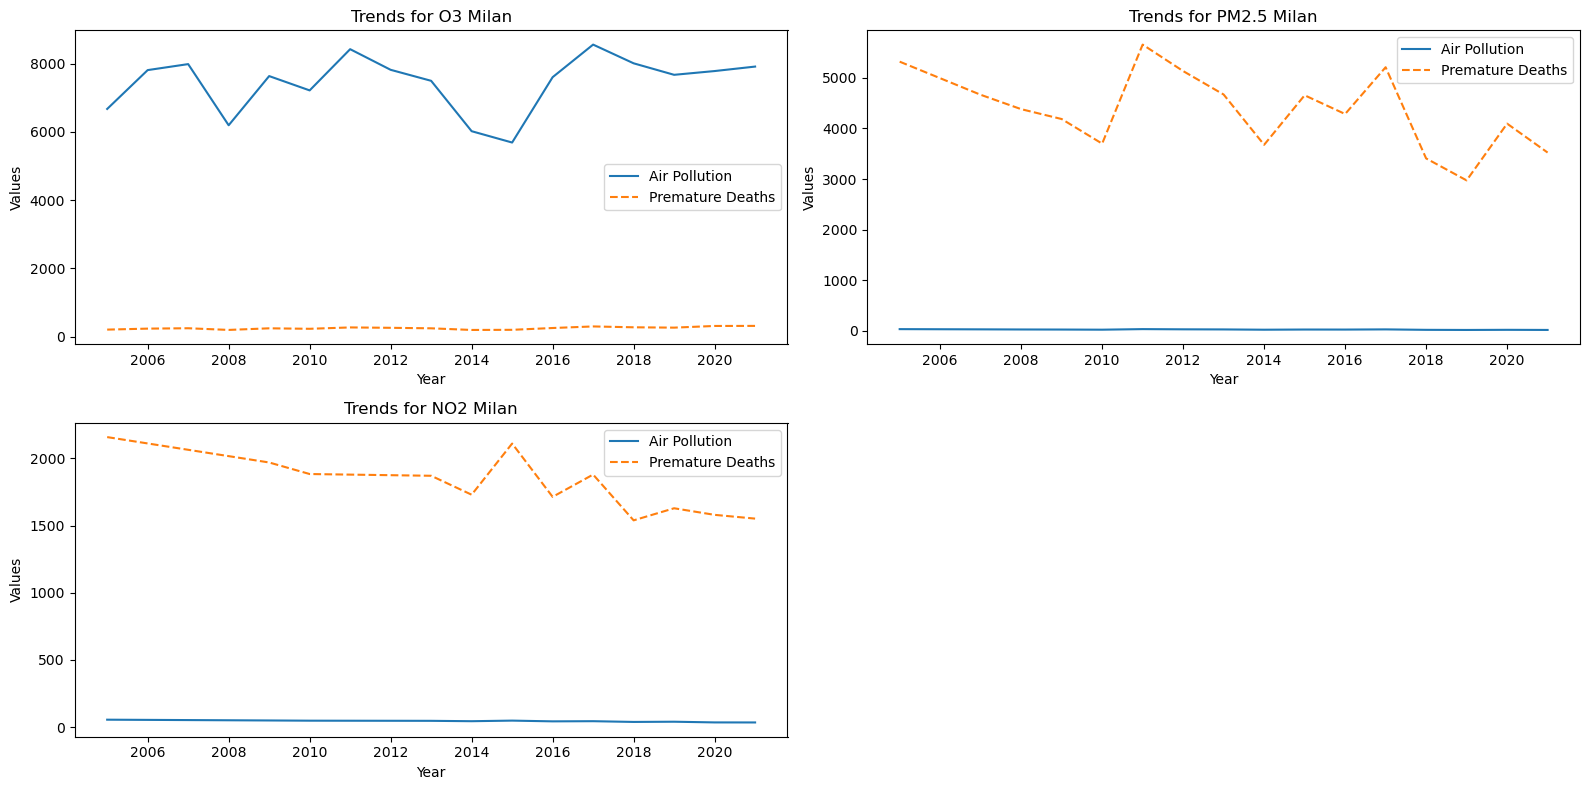

In [4]:
milan_group_polluant_year = df_milan.groupby(["Air Pollutant", 'Year'])[["Air Pollution Population Weighted Average [ug/m3]", "Premature Deaths"]].mean()
pollutants_milan = df_milan['Air Pollutant'].unique()
n_pollutants_milan = len(pollutants_milan)

graph_prem_deaths_city(milan_group_polluant_year, n_pollutants=n_pollutants_milan, city="Milan", pollutants=pollutants_milan)

Impact of NO2, O3, and PM 2.5 on premature deaths in Sassary, Sardegna, Italy

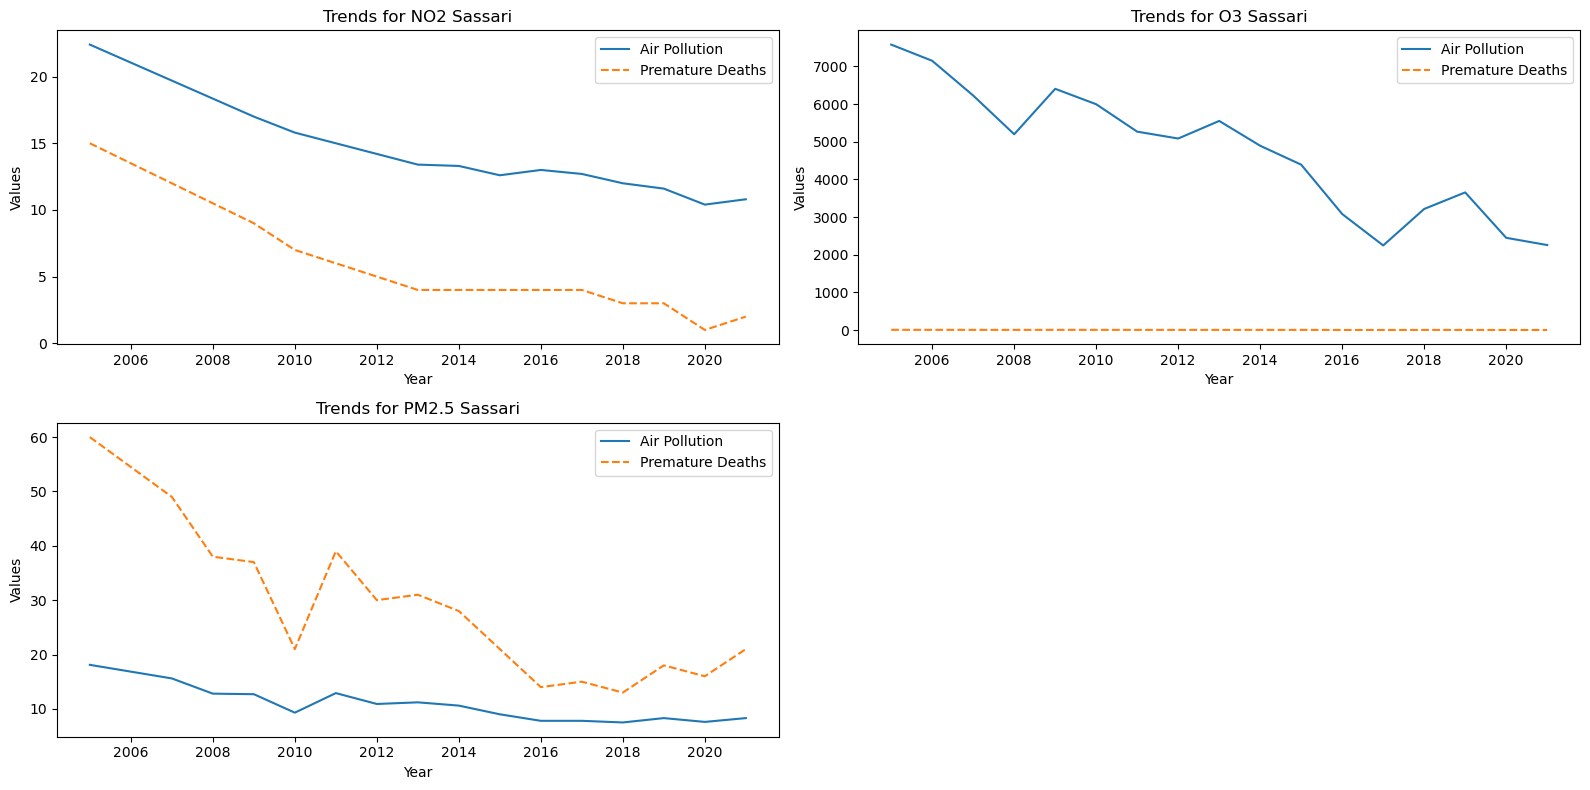

In [5]:
sassari_group_polluant_year = df_sassari.groupby(["Air Pollutant", 'Year'])[["Air Pollution Population Weighted Average [ug/m3]", "Premature Deaths"]].mean()
pollutants_sassari = df_sassari['Air Pollutant'].unique()
n_pollutants_sassari = len(pollutants_sassari)
graph_prem_deaths_city(sassari_group_polluant_year, n_pollutants=n_pollutants_sassari, city="Sassari", pollutants=pollutants_sassari)

#### Linear Regression for Milan and Sassari

In [6]:
def linear_reg(df_city, pollutants, city, n_pollutants=3):
    plt.figure(figsize=(10, 4 * n_pollutants))
    for i, pollutant in enumerate(pollutants, 1):
        if i <= 2: 
            plt.subplot(2, 2, i)
        else: 
            plt.subplot(2, 2, i)
                
        pollutant_data = df_city[df_city['Air Pollutant'] == pollutant][['Year', 'Air Pollution Population Weighted Average [ug/m3]', 'Premature Deaths']]
        X = pollutant_data[['Air Pollution Population Weighted Average [ug/m3]']]
        y = pollutant_data['Premature Deaths']
        
        model = LinearRegression()
        model.fit(X, y)
        
        predictions = model.predict(X)
        
        plt.scatter(X, y, label='Actual Data', color='blue')
        plt.plot(X, predictions, label='Linear Regression', color='red')
        plt.title(f'Linear Regression: {pollutant} vs. Premature Deaths in {city}')
        plt.xlabel(f'{pollutant} Air Pollution Population Weighted Average [ug/m3]')
        plt.ylabel('Premature Deaths')
        plt.legend()
        plt.tight_layout()

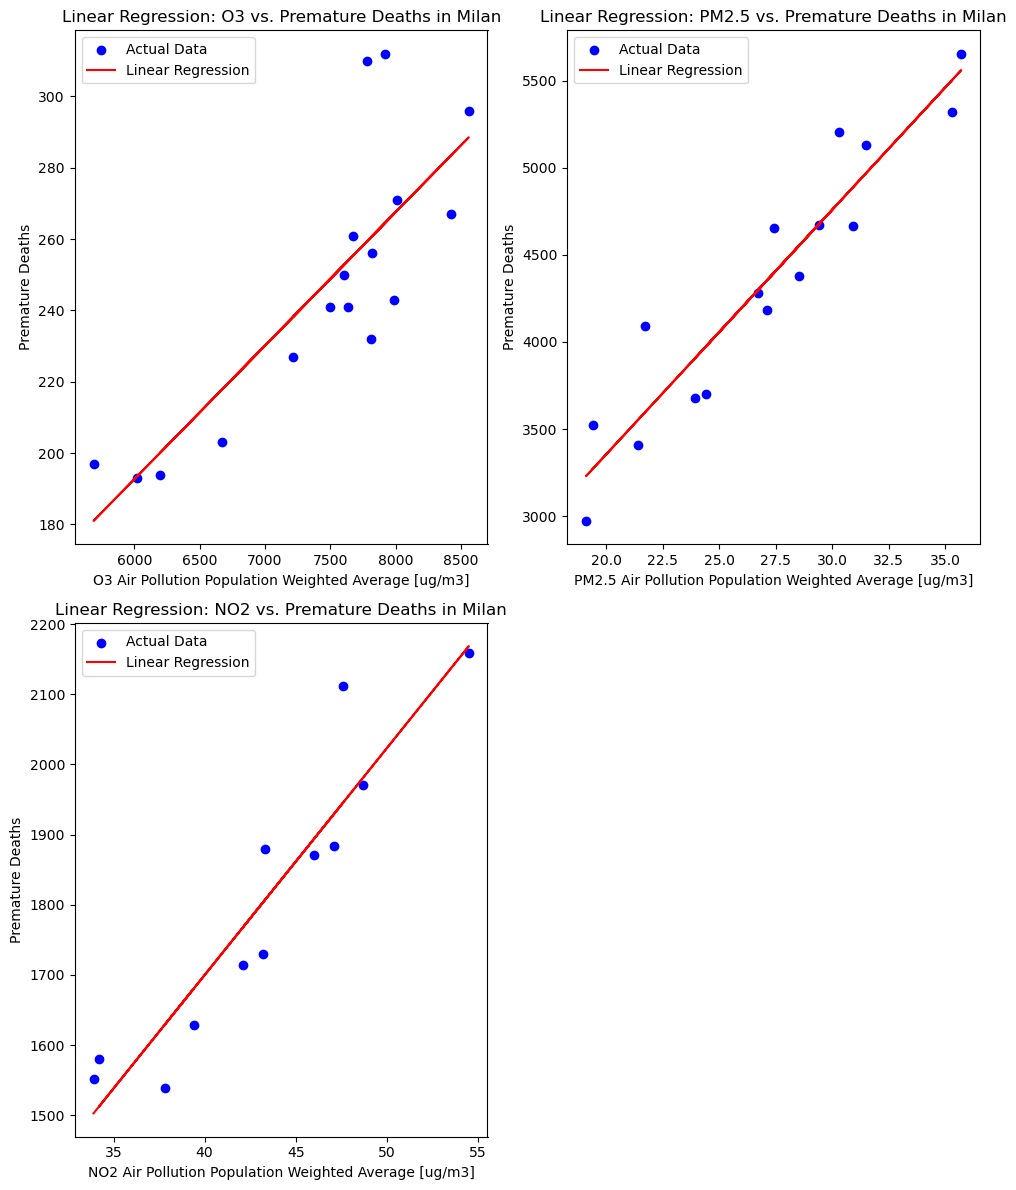

In [7]:
# Linear reg for Milan
linear_reg(df_milan, n_pollutants=n_pollutants_milan, city="Milan", pollutants=pollutants_milan)

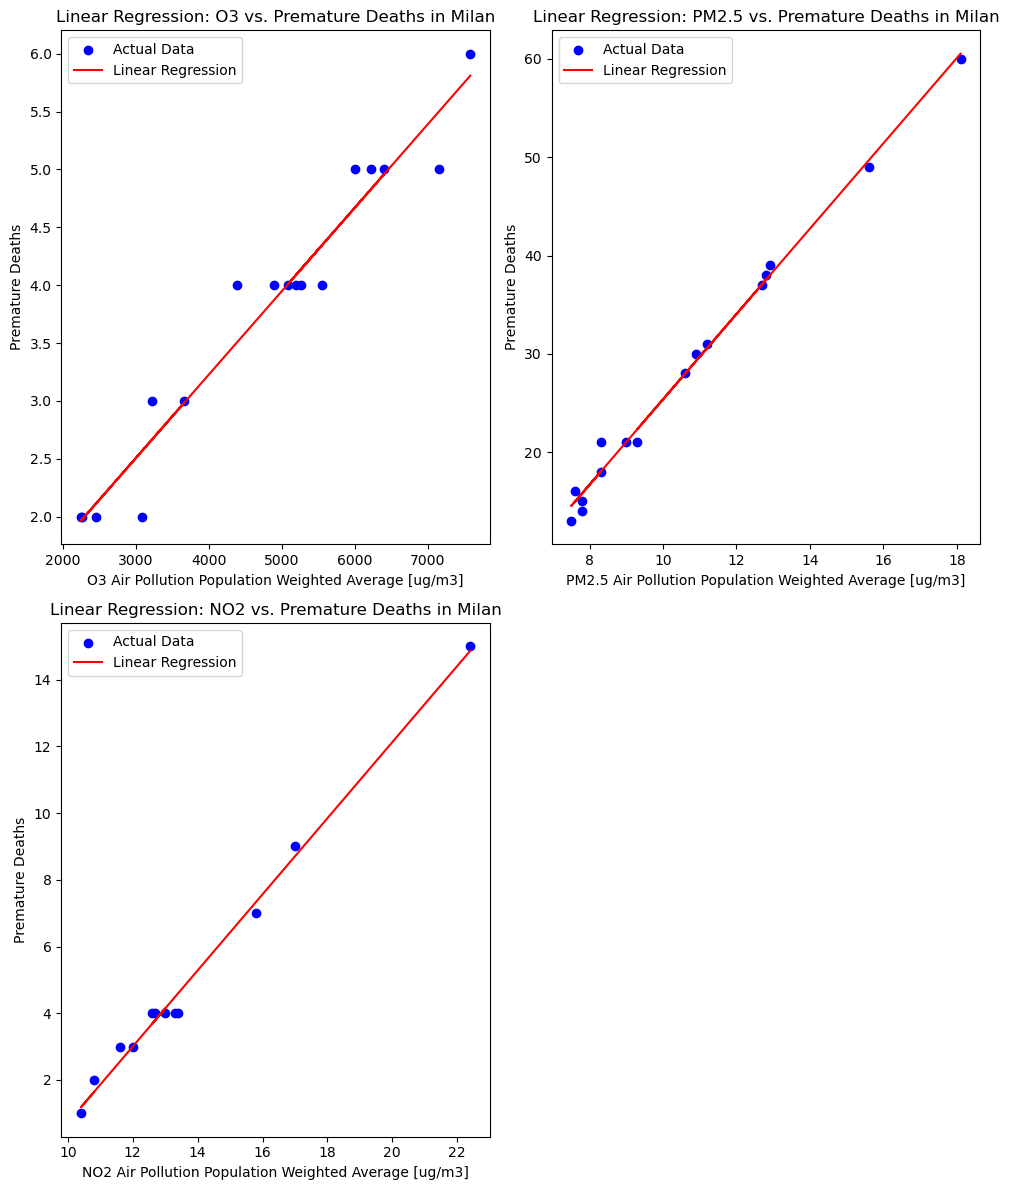

In [8]:
# Linear reg for Sassari
linear_reg(df_sassari, n_pollutants=n_pollutants_milan, city="Milan", pollutants=pollutants_milan)

# Italy and Milan death rate due to PM 2.5

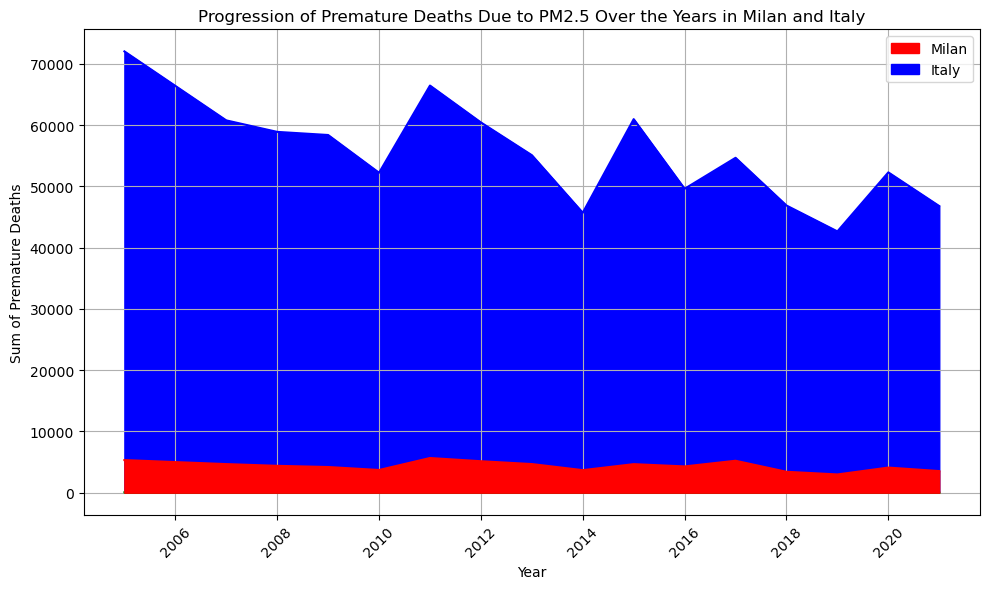

In [9]:
# Italy, Milan and Sassari death rate due to pm2.5
pm25_italy_done = data_italy.groupby('Year')["Premature Deaths"].sum()
pm25_deaths_milan = df_milan[df_milan['Air Pollutant'] == 'PM2.5'].groupby('Year')['Premature Deaths'].sum()
pm25_deaths_sassari = df_sassari[df_sassari['Air Pollutant'] == 'PM2.5'].groupby('Year')['Premature Deaths'].sum()

#Plotting Italy, Milan and Sassari
plt.figure(figsize=(10, 6))

plt.plot(pm25_deaths_milan.index, pm25_deaths_milan, color='red', zorder=5)
plt.fill_between(pm25_deaths_milan.index, pm25_deaths_milan, label="Milan", color="red", zorder=5)

plt.plot(pm25_deaths_sassari.index, pm25_deaths_sassari, color="green")
plt.fill_between(pm25_deaths_sassari.index, pm25_deaths_sassari, color="green", zorder=3, )

plt.plot(pm25_italy_done.index, pm25_italy_done, color="blue")
plt.fill_between(pm25_italy_done.index, pm25_italy_done, label="Italy", color="blue")

plt.title('Progression of Premature Deaths Due to PM2.5 Over the Years in Milan and Italy')
plt.xlabel('Year')
plt.ylabel('Sum of Premature Deaths')
plt.grid(True)  # Add grid for better readability
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.legend()
plt.show()

### Milan and other main european cities - Premature deaths VS PM2.5 levels of polution

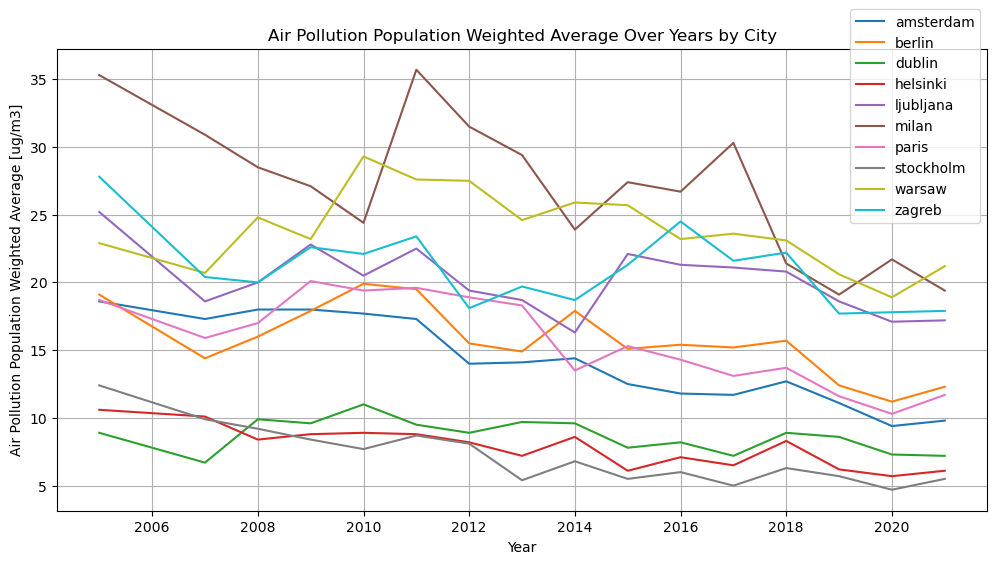

In [10]:
# plotting main european cities
eur_city = pd.read_csv("cleaned_data/merged_european_cities_data.csv")
pivoted_data = eur_city.pivot(index='Year', columns='City', values='Air Pollution Population Weighted Average [ug/m3]')
    
# Plotting
plt.figure(figsize=(12, 6))
for city in pivoted_data.columns:
    plt.plot(pivoted_data.index, pivoted_data[city], label=city)

plt.xlabel('Year')
plt.ylabel('Air Pollution Population Weighted Average [ug/m3]')
plt.title('Air Pollution Population Weighted Average Over Years by City')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.1))
plt.grid(True)